In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import glob

from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

import preseason.tools as sf
import preseason.onset_demise as od
import preseason.plotting as pp


In [ ]:
from importlib import reload

reload(od)

In [2]:
def create_composites(ds, dates, period):
    composites = {}
    composite_data = []
    for date in dates:
        start_date = date - pd.Timedelta(period,'w')
        end_date = date - pd.Timedelta(1,"d")
        
        subset = ds.sel(time=slice(start_date, end_date))
        
        composite = subset.mean(dim='time')
        composite_data.append(composite)
    
    composites = xr.concat(composite_data, dim='time')
    composites = composites.mean(dim='time')
    return composites

In [3]:
### Allows us to use dask to speed up some calculations ###
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=2)
client = Client(cluster)

In [4]:
### Selecting out Peru from the global data.
lat_radius = 40 # degrees lat/lon
lon_radius = 50
PERU_center = {'lat': slice(-5, -10), 'lon': slice(280, 285)}


In [5]:
sst_data_dir = '/data/deluge/reanalysis/REANALYSIS/ERA5/2D/4xdaily/sst/' 
sst_files = glob.glob(sst_data_dir+'sst.[12]*')
ds_sst = xr.open_mfdataset(sst_files,parallel=True, chunks={'time' : -1})

sst_data = ds_sst['sst']

In [6]:
sst_data

<xarray.DataArray 'sst' (time: 106888, latitude: 361, longitude: 720)>
dask.array<concatenate, shape=(106888, 361, 720), dtype=float32, chunksize=(124, 361, 720), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * time       (time) datetime64[ns] 1950-01-01 ... 2023-02-28T18:00:00
Attributes:
    units:      K
    long_name:  Sea surface temperature

In [7]:
sst_data = sst_data.resample(time="D").mean(dim='time')

In [8]:
sst_anom = sst_data - sst_data.mean(dim='time')

In [10]:
sst_anom

<xarray.DataArray 'sst' (time: 26722, latitude: 361, longitude: 720)>
dask.array<sub, shape=(26722, 361, 720), dtype=float32, chunksize=(1, 361, 720), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2023-02-28
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0

In [ ]:
sst_anom.to_netcdf('sst_anom_era5.nc')

In [11]:
precip_data_dir = '/data/deluge/reanalysis/REANALYSIS/ERA5/2D/daily/precip/'

precip_files = glob.glob(precip_data_dir+'precip.[12]*')


ds_p = xr.open_mfdataset(precip_files, parallel=True, chunks={'time': -1})

precip_data = ds_p['precip'].sel(latitude = PERU_center['lat'], longitude = PERU_center['lon'])

In [ ]:
precip_data

In [12]:
precip_data = precip_data.persist()

In [12]:
precip_anom = precip_data - precip_data.mean(dim='time')
precip_anom = precip_anom.chunk(chunks={'time':-1})


In [13]:
p_annual_cycle = sf.calc_annual_cycle(precip_data)

In [14]:
p_annual_cycle = p_annual_cycle.compute()

In [15]:
analysis_start = od.B17_analysis_start(p_annual_cycle)
analysis_start = analysis_start.persist()

In [17]:
onset = od.onset_B17(precip_anom, analysis_start).compute()

/home/gbromley/code/PreSeason/preseason/onset_demise.py:220: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output_sizes={"year": len(np.unique(data.time.dt.year))},


In [18]:
demise = od.demise_B17(precip_anom, analysis_start).compute()

/home/gbromley/code/PreSeason/preseason/onset_demise.py:239: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output_sizes={"year": len(np.unique(data.time.dt.year))},


In [19]:
onset.to_netcdf('onset_era5_peru.nc')

In [20]:
demise.to_netcdf('demise_era5_peru.nc')

In [9]:
onset = xr.open_dataarray('onset_era5_peru.nc')
demise = xr.open_dataarray('demise_era5_peru.nc')

In [10]:
center_loc_onset = onset.sel(latitude=-10, longitude=285)
center_loc_demise = demise.sel(latitude=-10, longitude=285)

In [12]:
early_onset = center_loc_onset.where(center_loc_onset < center_loc_onset.quantile(0.10))
late_onset = center_loc_onset.where(center_loc_onset > center_loc_onset.quantile(0.90))

In [11]:
early_demise = center_loc_demise.where(center_loc_demise < center_loc_demise.quantile(0.10))
late_demise = center_loc_demise.where(center_loc_demise > center_loc_demise.quantile(0.90))

In [36]:
onset.median()

<xarray.DataArray ()>
array(272.)

In [13]:
early_onset_dates = sf.calcDates(early_onset).dropna(dim='year')
late_onset_dates = sf.calcDates(late_onset).dropna(dim='year')

In [14]:
early_demise_dates = sf.calcDates(early_demise).dropna(dim='year')
late_demise_dates = sf.calcDates(late_demise).dropna(dim='year')

In [27]:
composites_early_onset = create_composites(sst_data, early_onset_dates, period=1)
composites_late_onset = create_composites(sst_data, late_onset_dates, period=1)

In [28]:
comp_diff = composites_early_onset - composites_late_onset

/home/gbromley/anaconda3/envs/obswetdryseason/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


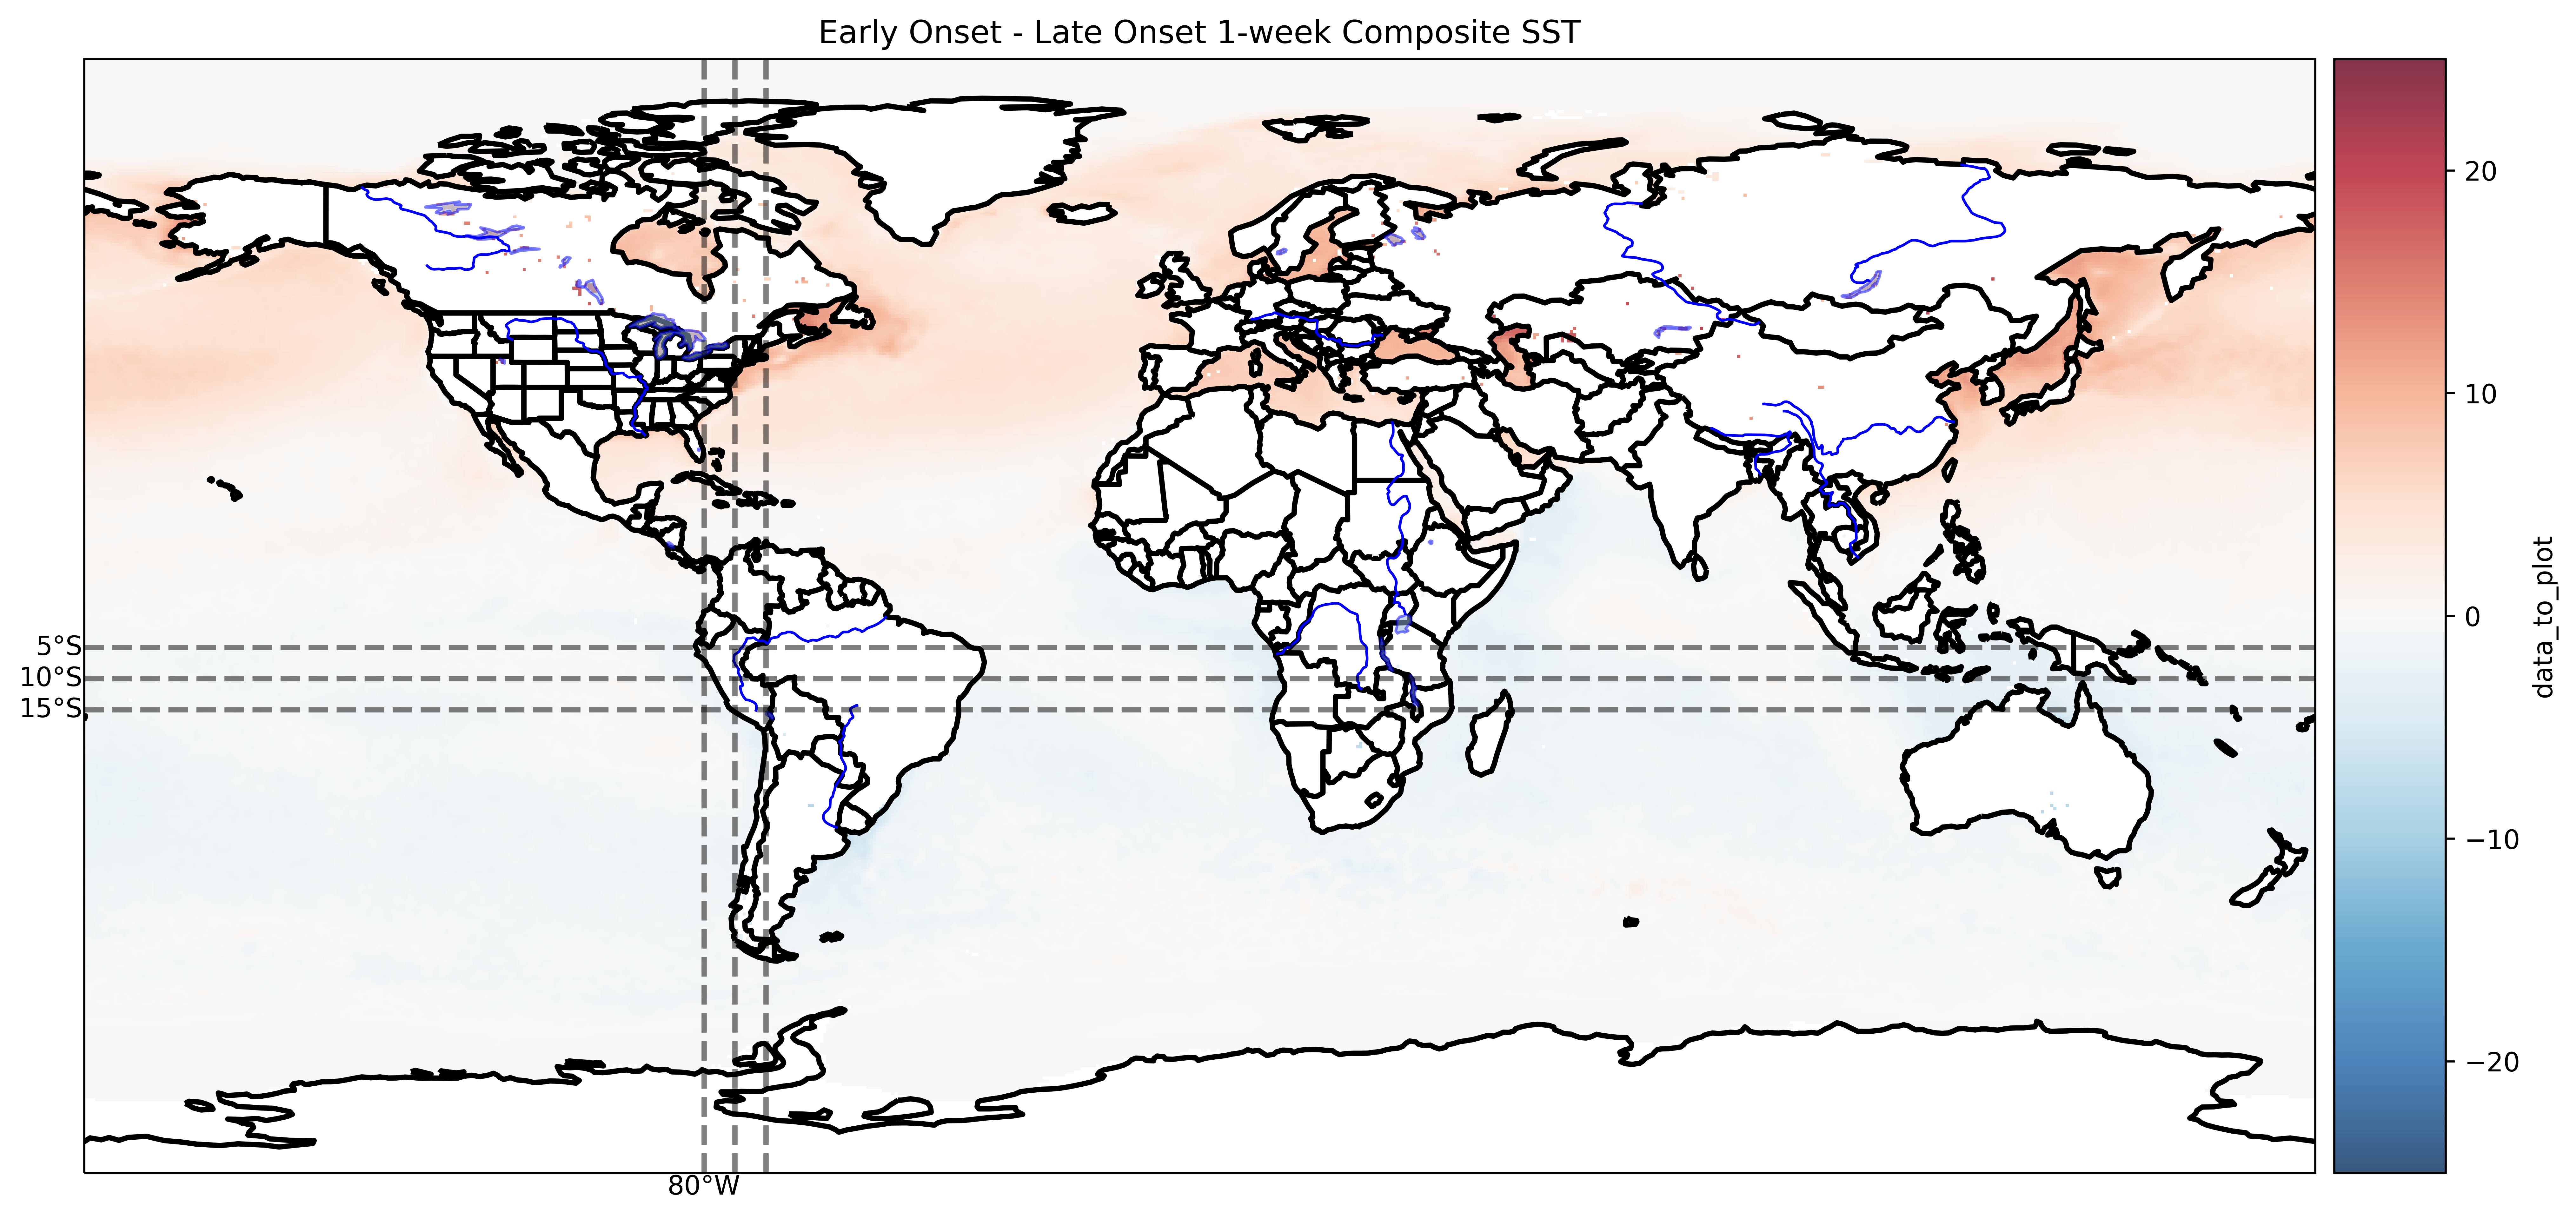

In [29]:
pp.plot_spatial_data(comp_diff, vmax=25, vmin=-25, cmap='RdBu_r', title='Early Onset - Late Onset 1-week Composite SST')

(array([ 1.,  3.,  6.,  6., 16., 11., 15.,  3.,  4.,  5.]),
 array([224. , 234.5, 245. , 255.5, 266. , 276.5, 287. , 297.5, 308. ,
        318.5, 329. ]),
 <BarContainer object of 10 artists>)

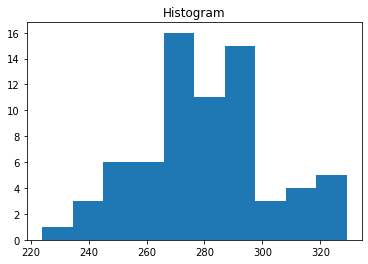

In [39]:
center_loc_onset.plot.hist()

In [30]:
composites_early_demise = create_composites(sst_data, early_demise_dates, period=1)
composites_late_demise = create_composites(sst_data, late_demise_dates, period=1)
comp_diff_demise = composites_early_demise - composites_late_demise

/home/gbromley/anaconda3/envs/obswetdryseason/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


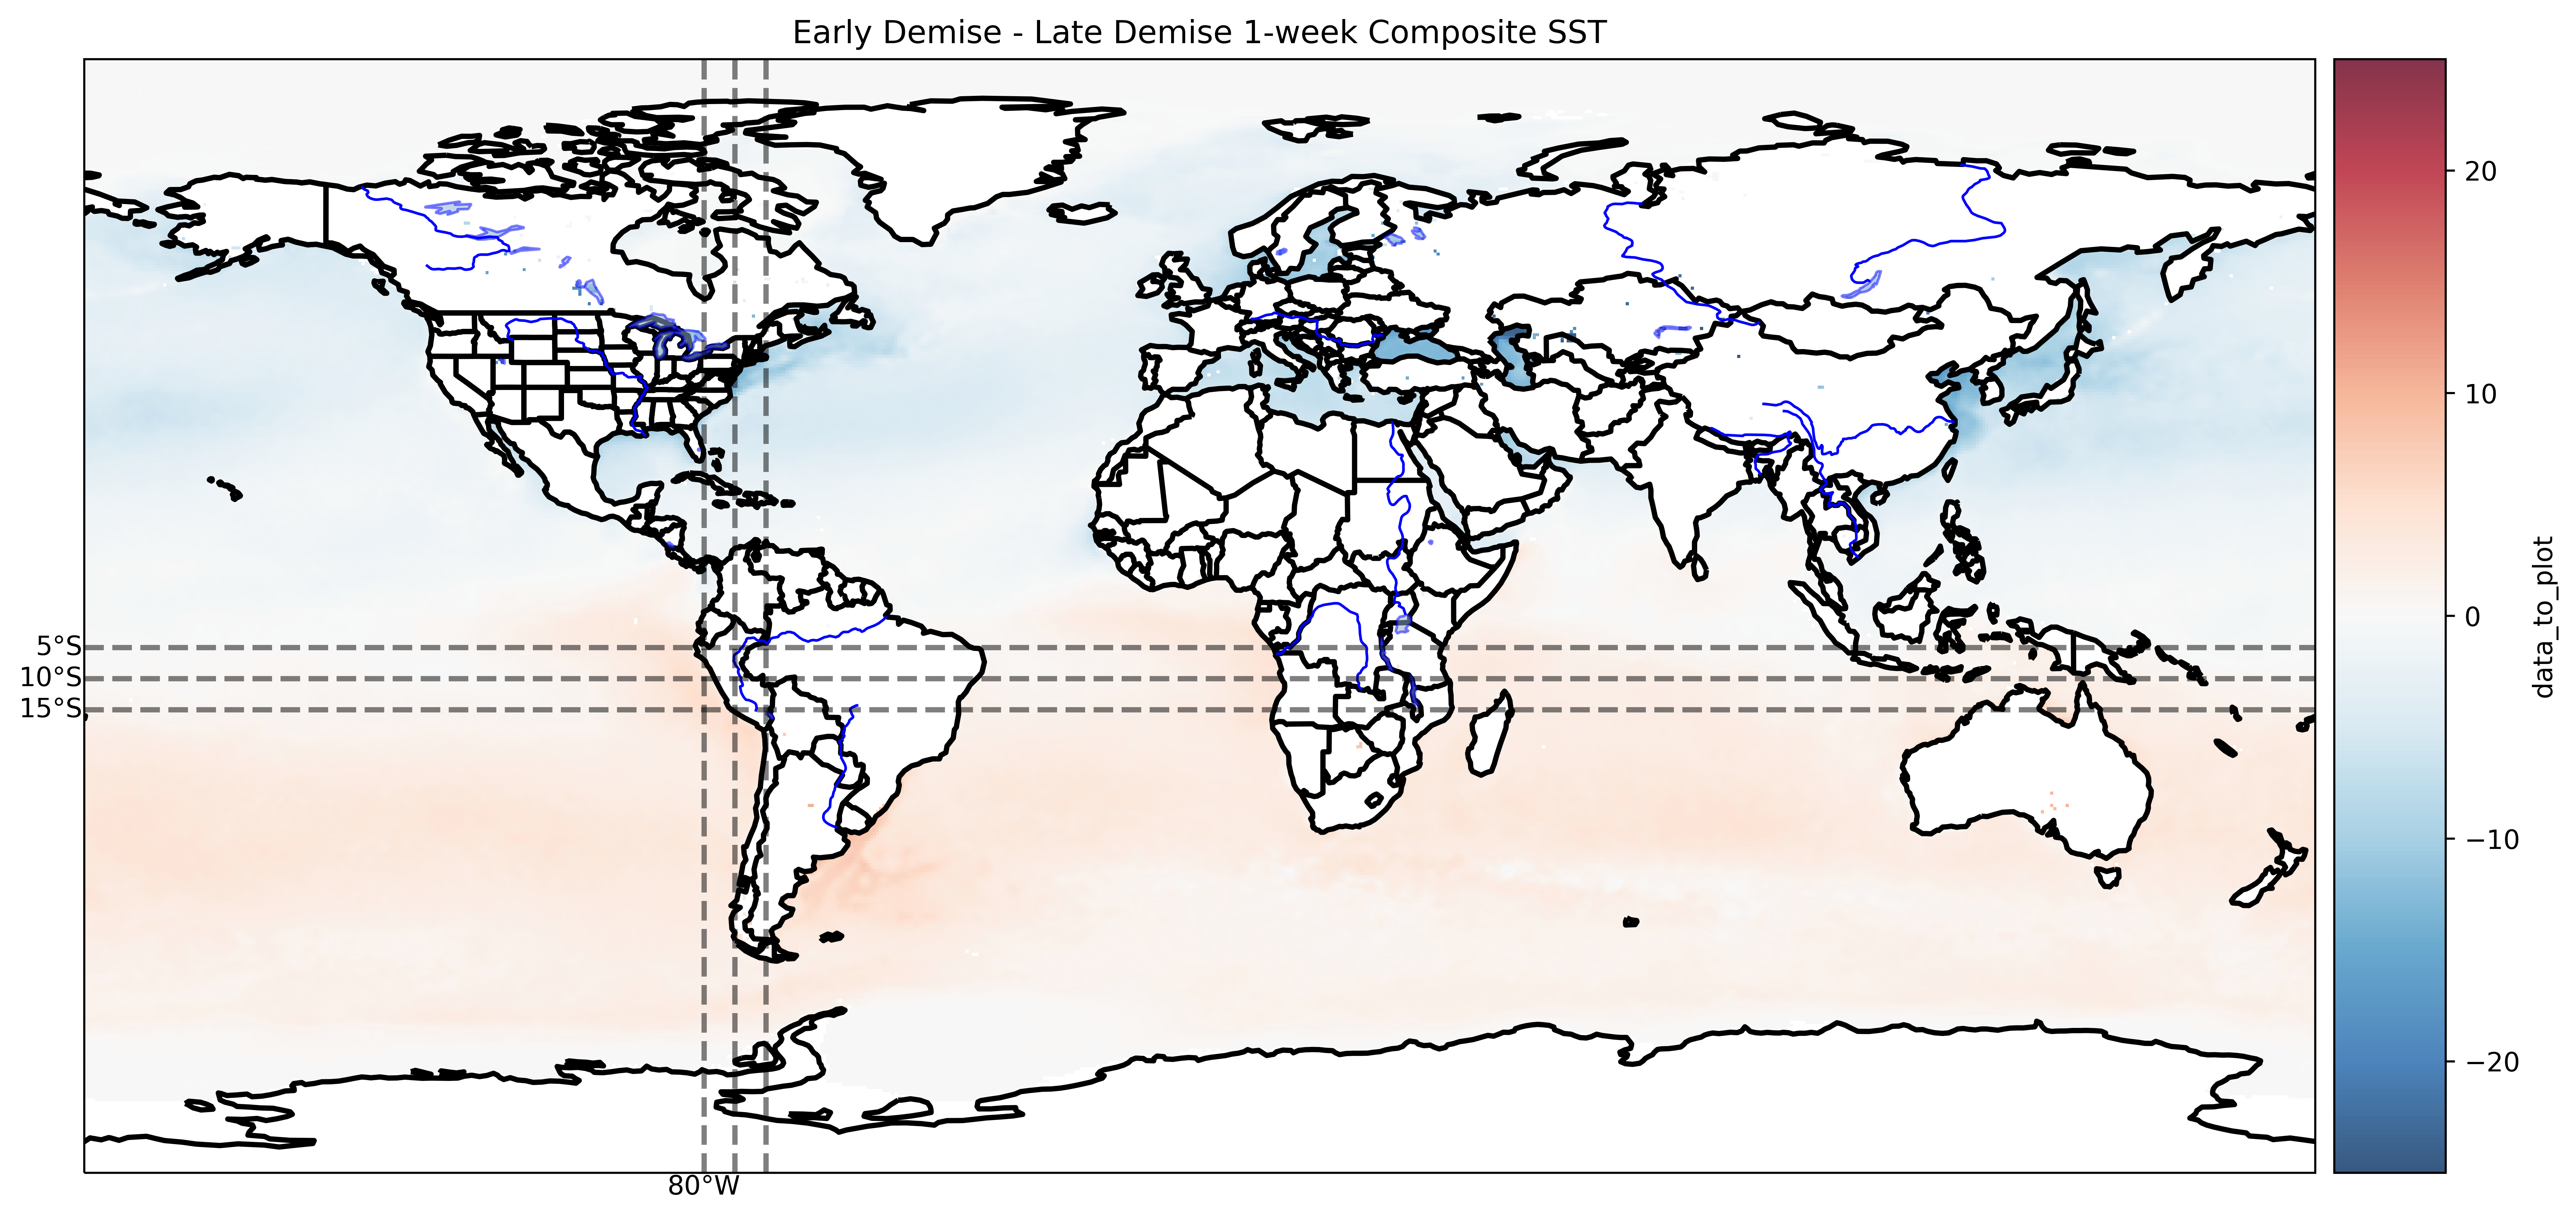

In [31]:
pp.plot_spatial_data(comp_diff_demise, vmax=25, vmin=-25, cmap='RdBu_r', title='Early Demise - Late Demise 1-week Composite SST')